# MRI Scan of 2D liver phantom

In [3]:
using PyPlot

### Loading Phantom Sample and information

In [53]:
data = transpose(readdlm("data/Liver2D.txt"));
println("data size: ", size(data))
print("data type: ", typeof(data))

data size: (51, 51)
data type: Array{Float64,2}

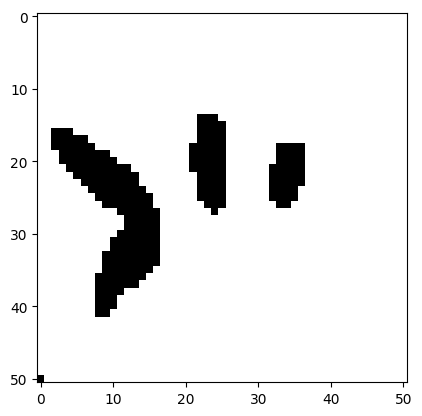

PyObject <matplotlib.image.AxesImage object at 0x0000000034358F60>

In [4]:
# displaying 2D phantom sample
figure(1);imshow(data,cmap="gray", interpolation="none"); # part of PyPlot
#figure(2);plot(1:size(data)[2],data[1,:])

In [82]:
# T2, T1, and proton information
T2 = 40e-3 #seconds
T1 = 500e-3 #seconds
pixelsize = 1.0 # mm per pixel
PHANTOMSIZE = pixelsize*size(data)[1]; # mm

if (size(data)[1]) % 2 != 0
    data = data[1:size(data)[1]- 1,1:size(data)[2]-1];
end

T2map = zeros(size(data)[1],size(data)[2]);
T2map[:,:] = T2;

T1map = zeros(size(data)[1],size(data)[2]);
T1map[:,:] = T1;

ProtonDensityMap = data;

xx = size(ProtonDensityMap)[1]; yy = size(ProtonDensityMap)[2];
vx = PHANTOMSIZE/xx; vy = PHANTOMSIZE/yy;
locationX = 2.0*repmat(-vx*xx/2:vx:vx*xx/2-1,1,yy);
locationY = 2.0*repmat((-vy*yy/2:vy:vy*yy/2-1)',xx,1);

### Scan Parameters:
* The field of view (FOV) = 60 mm
* The dwell time (DW) = $50 \ \mu sec$
  * dwell time is the time a the analogue digital converter (ADC) takes to record an amplidue point of the echo signal. This is equivalent to the the time between a amplitude measurement and the successive amplitdue measurement during the total smapling period. Each amplitude measurement correpsonds an instance of addding to the k-space data matrix (remember, not a single k-space point but points althroughout k-space). So if acquiring 256 samples, and the total sampling time at each instance during a pulse sequence was 5.12 ms, then the dwell time would be about 5.12 ms/256 = 20 mu.
* Imaging matrix Size = $ 51 \times 51 $
* Pre-phasing gradient duration (d1) = 5 msec
  * pre-phasing gradient duration is applied prior to excitation gradient an is meant to set phases of the spins to a specific phase (specific point in k-space like k = 0 or a phase = 0 relative to Larmor frequency).
* Echo time (TE) = 50 msec
* Repetition time (TR) = significantly longer than T1 
* The readout bandwidth (BW) = calculated from DW
  * bandwidth is a maeasure frequency breadth (span of frequencies) of singal (some form of information with periodic features). Bandwidth can either describe transmission of a singla or the recieiving of a singal. In this context, the bandwidth describes the recieving of the spin signals, meaning that this bandwidth is defined as the max span of frequencies possible between each sampling point (so 1/dwell time).
* Additional delay time (d2) = determined by TE
  * The total dealy time between the the excitation pulse (making spins all transverse) and the actual image acquistion (as measured from the center of the sampling instance).
* Gradient strength = determined by the FOV and BW

In [97]:
FOV = size(data)[1] + 10 #milimeters
DW = 50e-6 #seconds
matrixSize = [size(data)[1],size(data)[2]]
d1 = 5e-3 # pre-phasing gradient duration
TE = 50e-3
TR = 400000e-3
BW = 1/DW # bandwidth of frequencies being recieved
ReadoutAcquisitionWindow = DW*matrixSize[1] # Sampling time at each sampling instance
d2 = TE - (ReadoutAcquisitionWindow/2.)-d1
GradientX = BW/FOV   # Hz/mm
GradientYi = (GradientX*DW)/d1
GradientX1 = -GradientYi*(round(matrixSize[1]/2))
adcStartTime = d1+d2+DW #Acquistion start time
adcEndTime = d1+d2+ReadoutAcquisitionWindow;#Acquistion end time

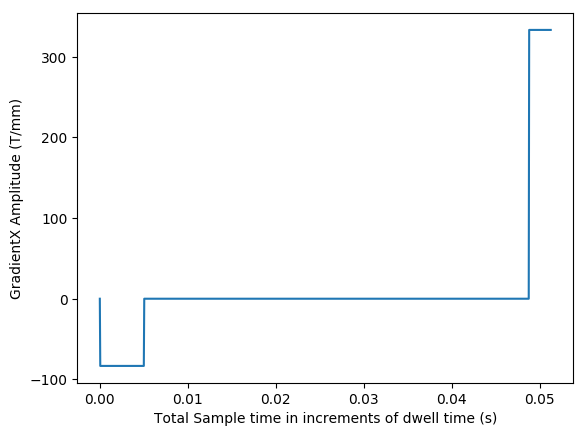

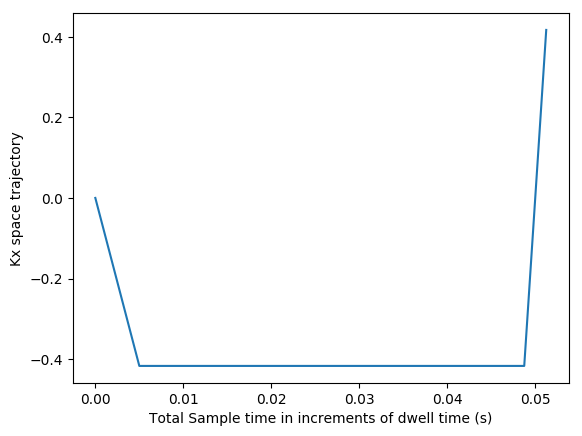

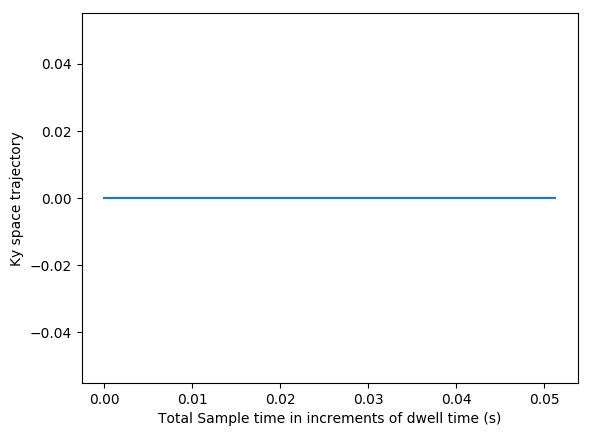

In [98]:
timeSampled = 0:DW:adcEndTime
GxWaveform = vcat(0.,GradientX1*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), GradientX*ones(size(adcStartTime:DW:adcEndTime)));
figure(1); plot(timeSampled,GxWaveform)
xlabel("Total Sample time in increments of dwell time (s)")
ylabel("GradientX Amplitude (T/mm)")

trajectory_kx = cumsum(GxWaveform)*DW;
figure(2); plot(timeSampled,trajectory_kx)
xlabel("Total Sample time in increments of dwell time (s)")
ylabel("Kx space trajectory")

GyWaveform = vcat(0.,0.*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), zeros(size(adcStartTime:DW:adcEndTime)));
trajectory_ky = cumsum(GyWaveform)*DW;
figure(3); plot(timeSampled,trajectory_ky)
xlabel("Total Sample time in increments of dwell time (s)")
ylabel("Ky space trajectory")
acquisition_trajectory_kx = trajectory_kx[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
acquisition_trajectory_ky = trajectory_ky[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
acquisition_timeSampled = timeSampled[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

### 1D k-space data at each acquistion time  instance

In [99]:
function MRIscan(t,kx,ky,pd,T2,T1,X,Y)
    kdata = zeros(Complex{Float64},size(t))
    i = complex(0,1)
    for cnt = 1:size(t)[1]
        kdata[cnt]=sum(pd.*exp.(-t[cnt]./T2).*(1.- exp.(-t[cnt]./T1)).*exp.(i*2*π*kx[cnt].*X).*exp.(i*2*π*ky[cnt].*Y))
    end
    return kdata
end

MRIscan (generic function with 1 method)

In [100]:
size(acquisition_timeSampled)[1];size(acquisition_trajectory_kx)[1]

50

In [101]:
size(locationY)

(50, 50)

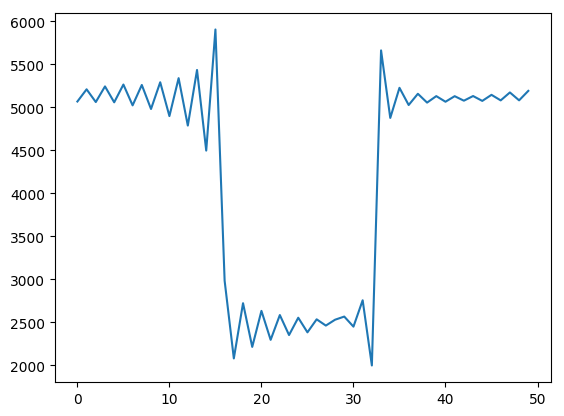

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000032E38B38>

In [102]:
kdata = MRIscan(acquisition_timeSampled,acquisition_trajectory_kx,acquisition_trajectory_ky,ProtonDensityMap[:],T2map[:],T1map[:],locationX[:],locationY[:]);
imgdata = fftshift(fft(fftshift(kdata)));
plot(abs.(imgdata))

### Computing 2D k-trajectory for all TR abd k-space data

In [103]:
# kSpaceData2D = zeros(Complex{Float64,},matrixSize[1],matrixSize[2])
kSpaceData2D = SharedArray{Complex{Float64,}}((matrixSize[1],matrixSize[2]))

timeSampled = 0:DW:adcEndTime
acquisition_timeSampled = timeSampled[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

GxWaveform = vcat(0.,GradientX1*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), GradientX*ones(size(adcStartTime:DW:adcEndTime)));
trajectory_kx = cumsum(GxWaveform)*DW;
acquisition_trajectory_kx = trajectory_kx[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

for TRcount = 1:matrixSize[2]
    kyLocation = TRcount-round(matrixSize[2]/2)
    GyWaveform = vcat(0.,GradientYi*kyLocation.*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), zeros(size(adcStartTime:DW:adcEndTime)));
    trajectory_ky = cumsum(GyWaveform)*DW;
    acquisition_trajectory_ky = trajectory_ky[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
    kdata = MRIscan(acquisition_timeSampled,acquisition_trajectory_kx,acquisition_trajectory_ky,ProtonDensityMap[:],T2map[:],T1map[:],locationX[:],locationY[:]);
    kSpaceData2D[:,TRcount] = kdata;
end

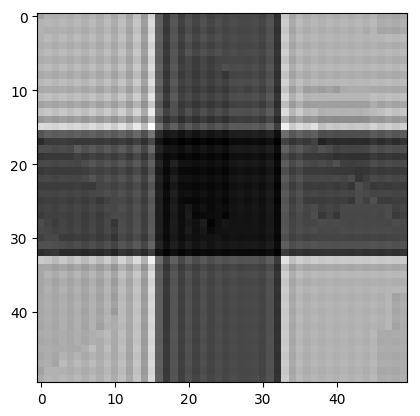

PyObject <matplotlib.image.AxesImage object at 0x000000002E25F3C8>

In [104]:
imgdata = fftshift(fft(fftshift(kSpaceData2D)));
imshow(abs.(imgdata),cmap="gray")

In [95]:
abs.(imgdata)

50×50 Array{Float64,2}:
 8.23302e-12     65.1642  4.73848e-12  …     64.5205  7.83412e-12     65.0702
 1.61344e-11  17111.5     5.42487e-12     16498.7     1.77186e-12  17111.6   
 8.06155e-12     65.1503  5.69642e-12        64.5866  8.40351e-12     65.0571
 1.63583e-11  17111.5     4.86153e-12     17112.1     3.53884e-12  17111.6   
 8.23561e-12     65.1449  5.21713e-12        64.5856  8.17153e-12     65.0519
 1.62643e-11  17111.5     4.30195e-12  …  17112.1     2.76897e-12  17111.6   
 7.84525e-12     65.1425  4.91876e-12        64.5864  8.36746e-12     65.0498
 1.83463e-11  17111.5     5.8999e-12      17112.1     1.08097e-12  17111.6   
 8.24589e-12     65.1415  5.73313e-12        64.5923  8.77727e-12     65.0492
 1.53019e-11  17111.5     4.98144e-12     17112.1     4.69653e-12  17111.6   
 9.08219e-12     65.1415  5.09399e-12  …     64.61    8.57973e-12     65.0498
 1.85428e-11  17111.5     8.01071e-12     16498.7     2.57554e-12  17111.6   
 8.38348e-12     65.1425  5.21837e-12   